<a href="https://colab.research.google.com/github/b-arac/nyc-air-quality/blob/main/NYC_Air_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dlt llama-index duckdb duckdb-engine

In [ ]:
import dlt
from dlt.sources.rest_api import rest_api_source


pipeline = dlt.pipeline(
    pipeline_name='nyc_air_quality',
    destination='duckdb'
)

air_quality_rest_source = rest_api_source(
    {
        "client": {
            "base_url": "https://data.cityofnewyork.us/resource/"
        },
        "resources": [
            "c3uy-2p5r.json"
        ],
    }
)



load_info = pipeline.run(air_quality_rest_source, table_name="nyc_air_quality")
print(load_info)

2025-12-14 13:23:49,347|[WARNING]|435|136809512615936|dlt|client.py|detect_paginator:365|Fallback `paginator` used: `SinglePagePaginator at 7c6d3c651790`. Please provide paginator manually.


Pipeline nyc_air_quality load step completed in 0.96 seconds
1 load package(s) were loaded to destination duckdb and into dataset nyc_air_quality_dataset
The duckdb destination used duckdb:////content/nyc_air_quality.duckdb location to store data
Load package 1765718628.6796951 is LOADED and contains no failed jobs


In [ ]:
df = pipeline.dataset().nyc_air_quality.df()

In [ ]:
df = df[["unique_id", "indicator_id", "name","measure", "measure_info", "geo_type_name", "geo_join_id", "geo_place_name", "time_period", "start_date", "data_value"]]

In [ ]:
df.data_value = df.data_value.astype(float)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df["start_date"] = pd.to_datetime(df["start_date"])

# Filter to PM2.5 only
df_pm25 = df[
    (df["name"] == "Fine particles (PM 2.5)") &
    (df["geo_type_name"] == "Borough")
].copy()

# Rename for clarity
df_pm25 = df_pm25.rename(columns={
    "geo_place_name": "borough",
    "data_value": "pm25"
})


df_pm25["month"] = df_pm25["start_date"].dt.to_period("M").dt.to_timestamp()
df_pm25["quarter"] = df_pm25["start_date"].dt.to_period("Q").astype(str)
df_pm25["year"] = df_pm25["start_date"].dt.year



monthly_pm25 = (
    df_pm25
    .groupby(["month", "borough"], as_index=False)
    .agg(avg_pm25=("pm25", "mean"))
)

def classify_risk(value):
    if value <= 9:
        return "low"
    elif value <= 12:
        return "medium"
    else:
        return "high"

monthly_pm25["risk_level"] = monthly_pm25["avg_pm25"].apply(classify_risk)


monthly_pm25["quarter"] = monthly_pm25["month"].dt.to_period("Q").astype(str)

q4_pm25 = (
    monthly_pm25
    .loc[monthly_pm25["quarter"].str.endswith("Q4")]
    .groupby("borough", as_index=False)
    .agg(
        q4_avg_pm25=("avg_pm25", "mean")
    )
    .sort_values("q4_avg_pm25", ascending=False)
)


citywide_trend = (
    monthly_pm25
    .groupby("month", as_index=False)
    .agg(citywide_avg_pm25=("avg_pm25", "mean"))
)

/tmp/ipython-input-4018018328.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_pm25["month"] = df_pm25["start_date"].dt.to_period("M").dt.to_timestamp()
/tmp/ipython-input-4018018328.py:21: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_pm25["quarter"] = df_pm25["start_date"].dt.to_period("Q").astype(str)


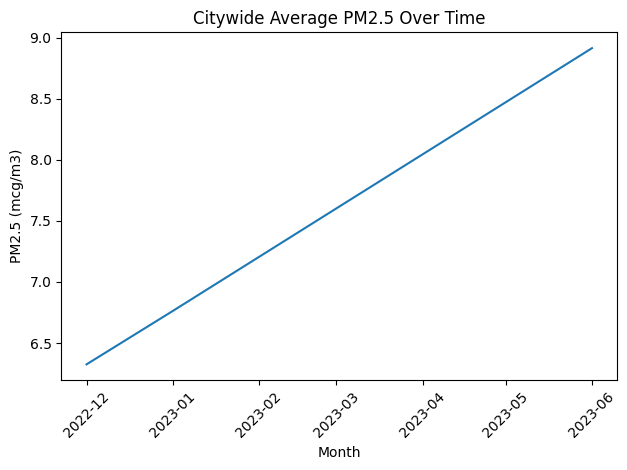

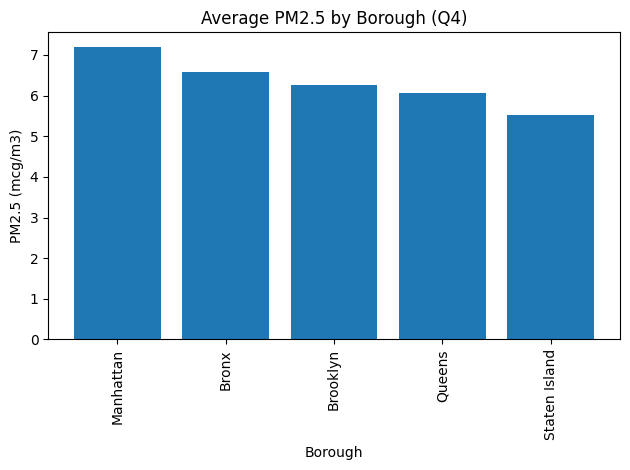

In [ ]:
plt.figure()
plt.plot(citywide_trend["month"], citywide_trend["citywide_avg_pm25"])
plt.title("Citywide Average PM2.5 Over Time")
plt.xlabel("Month")
plt.ylabel("PM2.5 (mcg/m3)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(q4_pm25["borough"], q4_pm25["q4_avg_pm25"])
plt.title("Average PM2.5 by Borough (Q4)")
plt.xlabel("Borough")
plt.ylabel("PM2.5 (mcg/m3)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

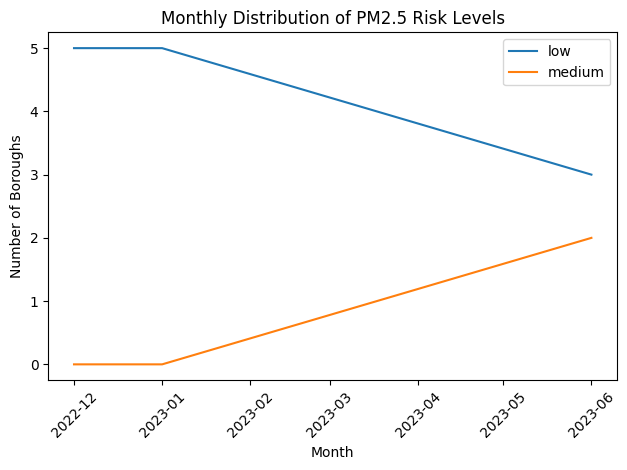

In [ ]:

risk_distribution = (
    monthly_pm25
    .groupby(["month", "risk_level"])
    .size()
    .reset_index(name="count")
)

pivot_risk = risk_distribution.pivot(
    index="month",
    columns="risk_level",
    values="count"
).fillna(0)

plt.figure()
for column in pivot_risk.columns:
    plt.plot(pivot_risk.index, pivot_risk[column], label=column)

plt.title("Monthly Distribution of PM2.5 Risk Levels")
plt.xlabel("Month")
plt.ylabel("Number of Boroughs")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
monthly_pm25

,month,borough,avg_pm25,risk_level,quarter
0,2022-12-01,Bronx,6.587404,low,2022Q4
1,2022-12-01,Brooklyn,6.261810,low,2022Q4
2,2022-12-01,Manhattan,7.197011,low,2022Q4
3,2022-12-01,Queens,6.054824,low,2022Q4
4,2022-12-01,Staten Island,5.524704,low,2022Q4
5,2023-01-01,Bronx,6.904677,low,2023Q1
6,2023-01-01,Brooklyn,6.730894,low,2023Q1
7,2023-01-01,Manhattan,7.306429,low,2023Q1
8,2023-01-01,Queens,6.629774,low,2023Q1
9,2023-01-01,Staten Island,6.236878,low,2023Q1


In [ ]:
import duckdb
from sqlalchemy import create_engine
engine = create_engine("duckdb:////content/nyc_air_quality.duckdb")

monthly_pm25.to_sql(
    "monthly_pm25",
    engine,
    if_exists="replace",
    index=False
)


-1

In [ ]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
from llama_index.core import SQLDatabase

from llama_index.core.query_engine import NLSQLTableQueryEngine


sql_database = SQLDatabase(engine, include_tables=["monthly_pm25"])
query_engine = NLSQLTableQueryEngine(sql_database)

/usr/local/lib/python3.12/dist-packages/duckdb_engine/__init__.py:184: DuckDBEngineWarning: duckdb-engine doesn't yet support reflection on indices
  warnings.warn(


In [ ]:
response = query_engine.query("How is risk status for Manhattan in 2023?")

In [ ]:
str(response)

'The risk status for Manhattan in 2023 fluctuated between low and medium levels. In January 2023, the risk level was reported as low, while in June 2023, it was classified as medium. It is important to stay informed about air quality updates and take necessary precautions during periods of higher risk.'

In [ ]:
response = query_engine.query("Is there any decline trend for any cities?")
str(response)

'Based on the average PM2.5 levels for different boroughs in New York City over time, there seems to be an increasing trend in air pollution levels from December 2022 to June 2023. The average PM2.5 levels have been rising steadily in all boroughs, indicating a potential decline in air quality during this period.'

In [ ]:
response = query_engine.query("What's the situation when compared across all cities?")
str(response)

'When comparing the average PM2.5 levels and associated risk levels across all cities, Manhattan and the Bronx have the highest average PM2.5 levels in the medium risk category. Queens, Brooklyn, and Staten Island have lower average PM2.5 levels in the low risk category. Overall, the air quality seems to be better in Queens, Brooklyn, and Staten Island compared to Manhattan and the Bronx.'